In [1]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.7 MB/s eta 0:00:00


In [2]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset, DataLoader
import pandas as pd
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix 
from sklearn.metrics import classification_report
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
df = pd.read_excel("sentipers.xlsx")

In [10]:
df

,text,polarity
0,اینک قصد داریم پرینتر دیگری از پرینترهای لیزری...,neutral
1,پرینتری چند کاره از رده‌ی Entry Level یا سطح م...,neutral
2,به هر صورت اکنون ما در دنیایی زندگی می‌کنیم، ...,neutral
3,به صورتی که توانایی کپی کردن، اسکن، فکس، پر...,neutral
4,به هر صورت معمولا چیزی که بیشتر کاربران از پری...,very good
...,...,...
15678,البته نمی‌توان گفت که سیستم خنک کننده کاملا بی...,good
15679,باتری با وجود تمام سخت افزارهای فوق‌العاده به ...,good
15680,نرم افزار به طور پیش فرض Retina MacBook Pro از...,good
15681,متاسفانه سایر برنامه‌ها بر روی این صفحه نمایش ...,bad


In [9]:
df['polarity'].unique()

array(['neutral', 'very good', 'good', 'bad', 'very bad'], dtype=object)

In [11]:
class CreateDataset(Dataset):

  def __init__(self, df):

    self.label_dict = {'good': 0, 'neutral': 1, 'very good': 2, 'bad' : 3, 'very bad' : 4}

    # Split the data into train and val_test
    train_val, test = train_test_split(df, test_size=0.1, random_state=10)

    # Split the val_test into validation and final test
    validation, test = train_test_split(test, test_size=0.5, random_state=10)

    self.train_df = train_val
    self.val_df = validation
    self.test_df = test

    model_name = "sentence-transformers/LaBSE"
    self.tokenizer = AutoTokenizer.from_pretrained(model_name) 
    self.init_data()

  def init_data(self):
    self.train_data = self.load_data(self.train_df)
    self.val_data = self.load_data(self.val_df)
    self.test_data = self.load_data(self.test_df)

  def load_data(self, df):

    text_list = df['text'].to_list()
    label_list = df['polarity']

    encoded_inputs = self.tokenizer.batch_encode_plus(text_list, add_special_tokens=True, padding="max_length", truncation=True, max_length= 512, return_tensors="pt")
    input_ids = encoded_inputs["input_ids"]
    attention_mask = encoded_inputs["attention_mask"]
    y = torch.tensor([self.label_dict.get(item, item) for item in label_list])
    
    dataset = TensorDataset(input_ids, attention_mask, y)
    print(len(dataset))
    return dataset

  def get_data_loaders(self, batch_size=32, shuffle=True):
    train_loader = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size
    )
  

    val_loader = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    test_loader = DataLoader(
      self.test_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    return train_loader, val_loader, test_loader
  


In [12]:
model_name = "sentence-transformers/LaBSE"
AutoModel.from_pretrained(model_name).config.hidden_size

768

In [13]:
class SentimentClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super(SentimentClassifier, self).__init__()
        self.labse = AutoModel.from_pretrained(model_name)
        # self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(self.labse.config.hidden_size, 512)
        self.act_func = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, num_classes)


    def forward(self, input_ids, attention_mask):
        outputs = self.labse(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        # pooled_output = self.dropout(pooled_output)
        out = self.act_func(self.fc1(pooled_output))
        out = self.act_func(self.fc2(out))
        out = self.act_func(self.fc3(out))
        out = self.act_func(self.fc4(out))
        out = self.fc5(out)

        return out


In [14]:
def train(model, iterator, optimizer, criterion):
    #print(iterator)
    
    epoch_loss = 0
    epoch_acc = 0
    pred = []
    labels = []
    
    model.train()
    
    for batch_idx, (inp_ids, mask_ids, y) in enumerate(iterator):

        optimizer.zero_grad() # clear gradients first
        torch.cuda.empty_cache() # releases all unoccupied cached memory 
         
        sequence = inp_ids.to(device)
        attn_mask = mask_ids.to(device)
        label = y.to(device)

       
        predictions = model(sequence, attn_mask)
        max_preds = predictions.argmax(dim = 1, keepdim = True).squeeze(1)
        correct = (max_preds==label).float()
        acc = correct.sum() / len(label)

        # print("max_preds :",max_preds )
        
        pred.extend(max_preds.tolist())
        labels.extend(label.tolist())
       
        
        loss = criterion(predictions, label)
        # print("loss :",loss )
        
      
        loss.backward()
        optimizer.step()
        

        epoch_loss += loss.item()
        epoch_acc += acc.item()


    return epoch_loss / len(iterator), epoch_acc / len(iterator), pred, labels

In [15]:
def evaluate(model, iterator, optimizer, criterion, flag_test_f):
    #print(iterator)
    epoch_loss = 0
    epoch_acc = 0
    pred = []
    labels = []

    model.eval()
    
    with torch.no_grad():
    
        for batch_idx, (inp_ids, mask_ids, y) in enumerate(iterator):
            #print(batch)

            sequence = inp_ids.to(device)
            attn_mask = mask_ids.to(device)
            label = y.to(device)
            predictions = model(sequence, attn_mask)
            max_preds = predictions.argmax(dim = 1, keepdim = True).squeeze(1)
            correct = (max_preds==label).float()
            acc = correct.sum() / len(label)

            pred.extend(max_preds.tolist())
            labels.extend(label.tolist())

            loss = criterion(predictions, label)
           
            epoch_loss += loss.item()
            epoch_acc += acc.item()

        if flag_test_f == True:

          print(f"report: {classification_report(pred,labels)}")
          print("test_confusion_matrix:\n", confusion_matrix(pred,labels))


        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), pred, labels

In [16]:
# Split the data into train and val_test
train_val, test = train_test_split(df, test_size=0.1, random_state=10)
# Split the val_test into validation and final test
validation, test = train_test_split(test, test_size=0.5, random_state=10)

datasett = CreateDataset(df)

14114
784
785


In [26]:
def runn(FarsTail_dataset, model, optimizer, criterion, epochs, batch_size, flag_test, flag_test_f, flag_val, flag_train, zero_shot_flag):

  N_EPOCHS = epochs

  batch_size  = batch_size

  if zero_shot_flag == True :
    test_loader = datasett.get_data_loaders(batch_size= batch_size)
  else:
      train_loader, val_loader, test_loader = datasett.get_data_loaders(batch_size= batch_size)

  dict_save = {"train_acc":[], "train_loss":[], "val_acc":[], "val_loss":[], "test_acc":[], "test_loss":[],"real_labels":[],"pre_labels" : []}

  for epoch in range(N_EPOCHS):

      if flag_train == True : 

        train_loss, train_acc, _, _ = train(model, train_loader, optimizer, criterion)
        dict_save['train_acc'].append(train_acc)
        dict_save['train_loss'].append(train_loss)

        print(f"Train: Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

      if flag_val == True:

        valid_loss, valid_acc, pred, labels = evaluate(model, val_loader, optimizer, criterion, flag_test_f)
        dict_save['val_acc'].append(valid_acc)
        dict_save['val_loss'].append(valid_loss)
        print(f"Validation: Epoch {epoch+1}, Loss: {valid_loss:.4f}, Accuracy: {valid_acc:.4f}")

      if flag_test == True:
        test_loss, test_acc, pred, labels = evaluate(model, test_loader, optimizer, criterion, flag_test_f)
        dict_save['test_acc'].append(test_acc)
        dict_save['test_loss'].append(test_loss)
        print(f"Test: Epoch {epoch+1}, Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

      if zero_shot_flag == True :
        test_loss, test_acc, pred, labels = evaluate(model, test_loader, optimizer, criterion, flag_test_f)
        ##'good'= 0, 'neutral'= 1, 'very good'= 2, 'bad' = 3, 'very bad' = 4
        mapping_label = {0 : 0 , 1 : 0, 2 : 0, 3 : 1, 4 : 1}

        pre_labels_zs = [mapping_label[l] for l in pred]


        print(f"report: {classification_report(pre_labels_zs,labels)}")
        print("test_confusion_matrix:\n", confusion_matrix(pre_labels_zs,labels))

        
      print('------------------------------------------------------------------------')

  return dict_save 

In [ ]:
model_name = "sentence-transformers/LaBSE"
num_classes = 5 
model = SentimentClassifier(model_name, num_classes).to(device)
for param in model.labse.parameters():
  param.requires_grad = False

# optimizer = optim.Adam(model.parameters())
optimizer = optim.AdamW(model.parameters(),lr=2e-5,eps=1e-6)
criterion = nn.CrossEntropyLoss().to(device)
dict_s = runn(df, model, optimizer, criterion, epochs = 10, batch_size = 32, flag_test = False, flag_test_f = False, flag_val = True, flag_train = True, zero_shot_flag = False)


Train: Epoch 1, Loss: 1.3971, Accuracy: 0.3754
Validation: Epoch 1, Loss: 1.1945, Accuracy: 0.5463
------------------------------------------------------------------------
Train: Epoch 2, Loss: 1.0871, Accuracy: 0.5513
Validation: Epoch 2, Loss: 0.9693, Accuracy: 0.6150
------------------------------------------------------------------------
Train: Epoch 3, Loss: 0.9591, Accuracy: 0.5943
Validation: Epoch 3, Loss: 0.8999, Accuracy: 0.6362
------------------------------------------------------------------------
Train: Epoch 4, Loss: 0.9042, Accuracy: 0.6237
Validation: Epoch 4, Loss: 0.8716, Accuracy: 0.6650
------------------------------------------------------------------------
Train: Epoch 5, Loss: 0.8719, Accuracy: 0.6394
Validation: Epoch 5, Loss: 0.8591, Accuracy: 0.6637
------------------------------------------------------------------------
Train: Epoch 6, Loss: 0.8493, Accuracy: 0.6490
Validation: Epoch 6, Loss: 0.8451, Accuracy: 0.6725
-----------------------------------------

In [18]:
def save_checkpoint(state, filename):
    model_save_name = filename
    path = F"/content/drive/MyDrive/{model_save_name}" 
    print("=> Saving checkpoint")
    torch.save(state, path)


def load_checkpoint(checkpoint,model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    list_acc_loss = checkpoint["dict_ss"]
    return model, list_acc_loss

In [ ]:
checkpoint_name =  "my_checkpoint_tamrin4_nlp_q2_task1.pth.tar"
checkpoint = {'state_dict' : model.state_dict(),
              'dict_ss' : dict_s}
save_checkpoint(checkpoint, filename=checkpoint_name)

=> Saving checkpoint


In [ ]:
checkpoint_name =  "my_checkpoint_tamrin4_nlp_q2_task1.pth.tar"
path = F"/content/drive/My Drive/{checkpoint_name}" 
save_list_task2 = load_checkpoint(torch.load(path),_)

In [ ]:
def plott(a,b,title,y_label, x_size): 

    #plt.figure(figsize=(25,8))
    plt.plot(range(0,x_size), a, color='r', label='train')
    plt.plot(range(0,x_size), b, color='b', label="val.")
    plt.xlabel("Epochs")
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

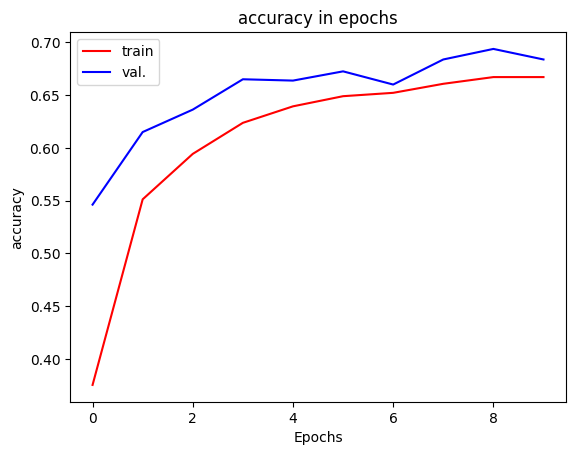

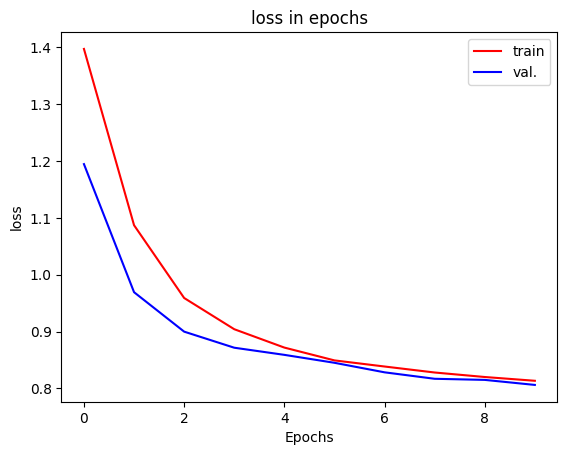

In [ ]:
plott(dict_s['train_acc'], dict_s['val_acc'], "accuracy in epochs", "accuracy", len(dict_s['val_acc']))
plott(dict_s['train_loss'], dict_s['val_loss'], "loss in epochs", "loss", len(dict_s['train_loss']))

In [ ]:
# test
dict_s_test = runn(df, model, optimizer, criterion, epochs = 10, batch_size = 32, flag_test = True, flag_test_f = True, flag_val = True, flag_train = False, zero_shot_flag = False)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:               precision    recall  f1-score   support

           0       0.63      0.64      0.64       252
           1       0.82      0.75      0.78       331
           2       0.64      0.71      0.67       122
           3       0.52      0.48      0.50        79
           4       0.00      0.00      0.00         0

    accuracy                           0.68       784
   macro avg       0.52      0.52      0.52       784
weighted avg       0.70      0.68      0.69       784

test_confusion_matrix:
 [[161  33  39  16   3]
 [ 55 249   6  16   5]
 [ 26   6  87   3   0]
 [ 13  17   4  38   7]
 [  0   0   0   0   0]]
Validation: Epoch 1, Loss: 0.8227, Accuracy: 0.6800


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:               precision    recall  f1-score   support

           0       0.57      0.53      0.55       241
           1       0.77      0.77      0.77       328
           2       0.62      0.66      0.64       129
           3       0.54      0.52      0.53        87
           4       0.00      0.00      0.00         0

    accuracy                           0.65       785
   macro avg       0.50      0.49      0.50       785
weighted avg       0.66      0.65      0.65       785

test_confusion_matrix:
 [[127  51  45  17   1]
 [ 48 251   6  20   3]
 [ 36   6  85   2   0]
 [ 13  18   2  45   9]
 [  0   0   0   0   0]]
Test: Epoch 1, Loss: 0.8624, Accuracy: 0.6471
------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:               precision    recall  f1-score   support

           0       0.63      0.64      0.64       252
           1       0.82      0.75      0.78       331
           2       0.64      0.71      0.67       122
           3       0.52      0.48      0.50        79
           4       0.00      0.00      0.00         0

    accuracy                           0.68       784
   macro avg       0.52      0.52      0.52       784
weighted avg       0.70      0.68      0.69       784

test_confusion_matrix:
 [[161  33  39  16   3]
 [ 55 249   6  16   5]
 [ 26   6  87   3   0]
 [ 13  17   4  38   7]
 [  0   0   0   0   0]]
Validation: Epoch 2, Loss: 0.8172, Accuracy: 0.6775


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:               precision    recall  f1-score   support

           0       0.57      0.53      0.55       241
           1       0.77      0.77      0.77       328
           2       0.62      0.66      0.64       129
           3       0.54      0.52      0.53        87
           4       0.00      0.00      0.00         0

    accuracy                           0.65       785
   macro avg       0.50      0.49      0.50       785
weighted avg       0.66      0.65      0.65       785

test_confusion_matrix:
 [[127  51  45  17   1]
 [ 48 251   6  20   3]
 [ 36   6  85   2   0]
 [ 13  18   2  45   9]
 [  0   0   0   0   0]]
Test: Epoch 2, Loss: 0.8742, Accuracy: 0.6438
------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:               precision    recall  f1-score   support

           0       0.63      0.64      0.64       252
           1       0.82      0.75      0.78       331
           2       0.64      0.71      0.67       122
           3       0.52      0.48      0.50        79
           4       0.00      0.00      0.00         0

    accuracy                           0.68       784
   macro avg       0.52      0.52      0.52       784
weighted avg       0.70      0.68      0.69       784

test_confusion_matrix:
 [[161  33  39  16   3]
 [ 55 249   6  16   5]
 [ 26   6  87   3   0]
 [ 13  17   4  38   7]
 [  0   0   0   0   0]]
Validation: Epoch 3, Loss: 0.8141, Accuracy: 0.6813


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:               precision    recall  f1-score   support

           0       0.57      0.53      0.55       241
           1       0.77      0.77      0.77       328
           2       0.62      0.66      0.64       129
           3       0.54      0.52      0.53        87
           4       0.00      0.00      0.00         0

    accuracy                           0.65       785
   macro avg       0.50      0.49      0.50       785
weighted avg       0.66      0.65      0.65       785

test_confusion_matrix:
 [[127  51  45  17   1]
 [ 48 251   6  20   3]
 [ 36   6  85   2   0]
 [ 13  18   2  45   9]
 [  0   0   0   0   0]]
Test: Epoch 3, Loss: 0.8698, Accuracy: 0.6471
------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:               precision    recall  f1-score   support

           0       0.63      0.64      0.64       252
           1       0.82      0.75      0.78       331
           2       0.64      0.71      0.67       122
           3       0.52      0.48      0.50        79
           4       0.00      0.00      0.00         0

    accuracy                           0.68       784
   macro avg       0.52      0.52      0.52       784
weighted avg       0.70      0.68      0.69       784

test_confusion_matrix:
 [[161  33  39  16   3]
 [ 55 249   6  16   5]
 [ 26   6  87   3   0]
 [ 13  17   4  38   7]
 [  0   0   0   0   0]]
Validation: Epoch 4, Loss: 0.8107, Accuracy: 0.6825


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:               precision    recall  f1-score   support

           0       0.57      0.53      0.55       241
           1       0.77      0.77      0.77       328
           2       0.62      0.66      0.64       129
           3       0.54      0.52      0.53        87
           4       0.00      0.00      0.00         0

    accuracy                           0.65       785
   macro avg       0.50      0.49      0.50       785
weighted avg       0.66      0.65      0.65       785

test_confusion_matrix:
 [[127  51  45  17   1]
 [ 48 251   6  20   3]
 [ 36   6  85   2   0]
 [ 13  18   2  45   9]
 [  0   0   0   0   0]]
Test: Epoch 4, Loss: 0.8618, Accuracy: 0.6471
------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:               precision    recall  f1-score   support

           0       0.63      0.64      0.64       252
           1       0.82      0.75      0.78       331
           2       0.64      0.71      0.67       122
           3       0.52      0.48      0.50        79
           4       0.00      0.00      0.00         0

    accuracy                           0.68       784
   macro avg       0.52      0.52      0.52       784
weighted avg       0.70      0.68      0.69       784

test_confusion_matrix:
 [[161  33  39  16   3]
 [ 55 249   6  16   5]
 [ 26   6  87   3   0]
 [ 13  17   4  38   7]
 [  0   0   0   0   0]]
Validation: Epoch 5, Loss: 0.8128, Accuracy: 0.6813


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:               precision    recall  f1-score   support

           0       0.57      0.53      0.55       241
           1       0.77      0.77      0.77       328
           2       0.62      0.66      0.64       129
           3       0.54      0.52      0.53        87
           4       0.00      0.00      0.00         0

    accuracy                           0.65       785
   macro avg       0.50      0.49      0.50       785
weighted avg       0.66      0.65      0.65       785

test_confusion_matrix:
 [[127  51  45  17   1]
 [ 48 251   6  20   3]
 [ 36   6  85   2   0]
 [ 13  18   2  45   9]
 [  0   0   0   0   0]]
Test: Epoch 5, Loss: 0.8652, Accuracy: 0.6471
------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:               precision    recall  f1-score   support

           0       0.63      0.64      0.64       252
           1       0.82      0.75      0.78       331
           2       0.64      0.71      0.67       122
           3       0.52      0.48      0.50        79
           4       0.00      0.00      0.00         0

    accuracy                           0.68       784
   macro avg       0.52      0.52      0.52       784
weighted avg       0.70      0.68      0.69       784

test_confusion_matrix:
 [[161  33  39  16   3]
 [ 55 249   6  16   5]
 [ 26   6  87   3   0]
 [ 13  17   4  38   7]
 [  0   0   0   0   0]]
Validation: Epoch 6, Loss: 0.8155, Accuracy: 0.6825


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:               precision    recall  f1-score   support

           0       0.57      0.53      0.55       241
           1       0.77      0.77      0.77       328
           2       0.62      0.66      0.64       129
           3       0.54      0.52      0.53        87
           4       0.00      0.00      0.00         0

    accuracy                           0.65       785
   macro avg       0.50      0.49      0.50       785
weighted avg       0.66      0.65      0.65       785

test_confusion_matrix:
 [[127  51  45  17   1]
 [ 48 251   6  20   3]
 [ 36   6  85   2   0]
 [ 13  18   2  45   9]
 [  0   0   0   0   0]]
Test: Epoch 6, Loss: 0.8676, Accuracy: 0.6471
------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:               precision    recall  f1-score   support

           0       0.63      0.64      0.64       252
           1       0.82      0.75      0.78       331
           2       0.64      0.71      0.67       122
           3       0.52      0.48      0.50        79
           4       0.00      0.00      0.00         0

    accuracy                           0.68       784
   macro avg       0.52      0.52      0.52       784
weighted avg       0.70      0.68      0.69       784

test_confusion_matrix:
 [[161  33  39  16   3]
 [ 55 249   6  16   5]
 [ 26   6  87   3   0]
 [ 13  17   4  38   7]
 [  0   0   0   0   0]]
Validation: Epoch 7, Loss: 0.8100, Accuracy: 0.6837


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:               precision    recall  f1-score   support

           0       0.57      0.53      0.55       241
           1       0.77      0.77      0.77       328
           2       0.62      0.66      0.64       129
           3       0.54      0.52      0.53        87
           4       0.00      0.00      0.00         0

    accuracy                           0.65       785
   macro avg       0.50      0.49      0.50       785
weighted avg       0.66      0.65      0.65       785

test_confusion_matrix:
 [[127  51  45  17   1]
 [ 48 251   6  20   3]
 [ 36   6  85   2   0]
 [ 13  18   2  45   9]
 [  0   0   0   0   0]]
Test: Epoch 7, Loss: 0.8578, Accuracy: 0.6515
------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:               precision    recall  f1-score   support

           0       0.63      0.64      0.64       252
           1       0.82      0.75      0.78       331
           2       0.64      0.71      0.67       122
           3       0.52      0.48      0.50        79
           4       0.00      0.00      0.00         0

    accuracy                           0.68       784
   macro avg       0.52      0.52      0.52       784
weighted avg       0.70      0.68      0.69       784

test_confusion_matrix:
 [[161  33  39  16   3]
 [ 55 249   6  16   5]
 [ 26   6  87   3   0]
 [ 13  17   4  38   7]
 [  0   0   0   0   0]]
Validation: Epoch 8, Loss: 0.8171, Accuracy: 0.6813


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:               precision    recall  f1-score   support

           0       0.57      0.53      0.55       241
           1       0.77      0.77      0.77       328
           2       0.62      0.66      0.64       129
           3       0.54      0.52      0.53        87
           4       0.00      0.00      0.00         0

    accuracy                           0.65       785
   macro avg       0.50      0.49      0.50       785
weighted avg       0.66      0.65      0.65       785

test_confusion_matrix:
 [[127  51  45  17   1]
 [ 48 251   6  20   3]
 [ 36   6  85   2   0]
 [ 13  18   2  45   9]
 [  0   0   0   0   0]]
Test: Epoch 8, Loss: 0.8643, Accuracy: 0.6471
------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:               precision    recall  f1-score   support

           0       0.63      0.64      0.64       252
           1       0.82      0.75      0.78       331
           2       0.64      0.71      0.67       122
           3       0.52      0.48      0.50        79
           4       0.00      0.00      0.00         0

    accuracy                           0.68       784
   macro avg       0.52      0.52      0.52       784
weighted avg       0.70      0.68      0.69       784

test_confusion_matrix:
 [[161  33  39  16   3]
 [ 55 249   6  16   5]
 [ 26   6  87   3   0]
 [ 13  17   4  38   7]
 [  0   0   0   0   0]]
Validation: Epoch 9, Loss: 0.8162, Accuracy: 0.6825


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:               precision    recall  f1-score   support

           0       0.57      0.53      0.55       241
           1       0.77      0.77      0.77       328
           2       0.62      0.66      0.64       129
           3       0.54      0.52      0.53        87
           4       0.00      0.00      0.00         0

    accuracy                           0.65       785
   macro avg       0.50      0.49      0.50       785
weighted avg       0.66      0.65      0.65       785

test_confusion_matrix:
 [[127  51  45  17   1]
 [ 48 251   6  20   3]
 [ 36   6  85   2   0]
 [ 13  18   2  45   9]
 [  0   0   0   0   0]]
Test: Epoch 9, Loss: 0.8673, Accuracy: 0.6460
------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:               precision    recall  f1-score   support

           0       0.63      0.64      0.64       252
           1       0.82      0.75      0.78       331
           2       0.64      0.71      0.67       122
           3       0.52      0.48      0.50        79
           4       0.00      0.00      0.00         0

    accuracy                           0.68       784
   macro avg       0.52      0.52      0.52       784
weighted avg       0.70      0.68      0.69       784

test_confusion_matrix:
 [[161  33  39  16   3]
 [ 55 249   6  16   5]
 [ 26   6  87   3   0]
 [ 13  17   4  38   7]
 [  0   0   0   0   0]]
Validation: Epoch 10, Loss: 0.8041, Accuracy: 0.6863
report:               precision    recall  f1-score   support

           0       0.57      0.53      0.55       241
           1       0.77      0.77      0.77       328
           2       0.62      0.66      0.64       129
           3       0.54      0.52      0.53        87
           4       0.00      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# zero-shot 

In [19]:
df2 = pd.read_csv("snapfood_testset.csv")

In [ ]:
df2

,comment,label
0,خواهشا خواهشا خواهشا واسه ارسال شیرینیها یه فک...,HAPPY
1,غذا گرم رسید کیفیت و پخت گوشت عالی بود,HAPPY
2,قیمت سس شکلات روی بسته بندی ۱۵۰۰۰ بود ولی قیمت...,SAD
3,عکس توی پیج یه شیرینی شکری روشن رنگ هست که همم...,SAD
4,باز هم میگم، پیتزا نباید اینقد چرب باشه,SAD
...,...,...
6995,سطح پیتزا سوخته بود متاسفانه و ارزش اون پولو ن...,SAD
6996,بسته بندی خیلی بسیار بد شده,SAD
6997,سلام خسته نباشید همه چی خوب بود فقط یک مقدار م...,HAPPY
6998,غذا سرد و کیفیت قابل قبول نبود,SAD


In [20]:
class CreateDataset_zs(Dataset):

  def __init__(self, df):

    self.label_dict = {'HAPPY': 0,'SAD' : 1}

    
    self.data_f = df

    model_name = "sentence-transformers/LaBSE"
    self.tokenizer = AutoTokenizer.from_pretrained(model_name) 
    self.init_data()

  def init_data(self):
    self.dataa = self.load_data(self.data_f)

  def load_data(self, df):

    text_list = df['comment'].to_list()
    label_list = df['label'].to_list()
    # print("label_list :" label_list)

    encoded_inputs = self.tokenizer.batch_encode_plus(text_list, add_special_tokens=True, padding="max_length", truncation=True, max_length= 512, return_tensors="pt")
    input_ids = encoded_inputs["input_ids"]
    attention_mask = encoded_inputs["attention_mask"]

    y = torch.tensor([self.label_dict.get(item, item) for item in label_list])
    
    dataset = TensorDataset(input_ids, attention_mask, y)
    print(len(dataset))
    return dataset

  def get_data_loaders(self, batch_size=32, shuffle=True):
    dataa_loader = DataLoader(
      self.dataa,
      shuffle=shuffle,
      batch_size=batch_size
    )

    return dataa_loader
  


In [21]:
# test
datasett = CreateDataset_zs(df2)

7000


In [24]:
model_name = "sentence-transformers/LaBSE"
num_classes = 5 
model = SentimentClassifier(model_name, num_classes).to(device)
 
optimizer = optim.AdamW(model.parameters(),lr=2e-5,eps=1e-6)
criterion = nn.CrossEntropyLoss().to(device)

checkpoint_name = "my_checkpoint_tamrin4_nlp_q2_task1.pth.tar"
path = F"/content/drive/My Drive/{checkpoint_name}" 
model, list_acc_loss = load_checkpoint(torch.load(path),model)

=> Loading checkpoint


In [ ]:
dict_s_zs = runn(datasett, model, optimizer, criterion, epochs = 10, batch_size = 32, flag_test = False, flag_test_f = False, flag_val = False, flag_train = False, zero_shot_flag = True)

In [27]:
dict_s_zs = runn(datasett, model, optimizer, criterion, epochs = 10, batch_size = 32, flag_test = False, flag_test_f = False, flag_val = False, flag_train = False, zero_shot_flag = True)

report:               precision    recall  f1-score   support

           0       0.82      0.69      0.75      4187
           1       0.63      0.78      0.70      2813

    accuracy                           0.73      7000
   macro avg       0.73      0.73      0.72      7000
weighted avg       0.75      0.73      0.73      7000

test_confusion_matrix:
 [[2884 1303]
 [ 616 2197]]
------------------------------------------------------------------------
report:               precision    recall  f1-score   support

           0       0.82      0.69      0.75      4187
           1       0.63      0.78      0.70      2813

    accuracy                           0.73      7000
   macro avg       0.73      0.73      0.72      7000
weighted avg       0.75      0.73      0.73      7000

test_confusion_matrix:
 [[2884 1303]
 [ 616 2197]]
------------------------------------------------------------------------
report:               precision    recall  f1-score   support

           0       

KeyboardInterrupt: ignored